In [8]:
import json
import munch
import os
import logging

from absl import app
from absl import flags
from absl import logging as absl_logging
import numpy as np
import tensorflow as tf

import equation as eqn
from solver import BSDESolver, BSDESolver_GRU

import matplotlib.pyplot as plt

In [2]:
exp_name = 'test'
log_dir = './logs' 

In [3]:
with open('configs/pricing_default_risk_d100.json') as json_data_file:
    config = json.load(json_data_file)

config = munch.munchify(config)
bsde = getattr(eqn, config.eqn_config.eqn_name)(config.eqn_config)

tf.keras.backend.set_floatx(config.net_config.dtype)

In [4]:
config

Munch({'eqn_config': Munch({'_comment': 'Nonlinear Black-Scholes equation with default risk in PNAS paper doi.org/10.1073/pnas.1718942115', 'eqn_name': 'PricingDefaultRisk', 'total_time': 1.0, 'dim': 100, 'num_time_interval': 40}), 'net_config': Munch({'y_init_range': [40, 50], 'num_hiddens': [110, 110], 'lr_values': [0.008, 0.008], 'lr_boundaries': [3000], 'num_iterations': 6000, 'batch_size': 64, 'valid_size': 256, 'logging_frequency': 100, 'dtype': 'float64', 'verbose': True})})

In [5]:
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [6]:
path_prefix = os.path.join(log_dir, exp_name)

with open('{}_config.json'.format(path_prefix), 'w') as outfile:
    json.dump(dict((name, getattr(config, name))
                   for name in dir(config) if not name.startswith('__')),
              outfile, indent=2)

In [7]:
absl_logging.get_absl_handler().setFormatter(logging.Formatter('%(levelname)-6s %(message)s'))
absl_logging.set_verbosity('info')
logging.info('Begin to solve %s ' % config.eqn_config.eqn_name)

In [9]:
bsde_gru_solver = BSDESolver_GRU(config, bsde)

In [10]:
training_history = bsde_gru_solver.train()

In [11]:
if bsde.y_init:
    logging.info('Y0_true: %.4e' % bsde.y_init)
    logging.info('relative error of Y0: %s',
                 '{:.2%}'.format(abs(bsde.y_init - training_history[-1, 2])/bsde.y_init))

In [12]:
np.savetxt('{}_gru_training_history.csv'.format(path_prefix),
           training_history,
           fmt=['%d', '%.5e', '%.5e', '%d'],
           delimiter=",",
           header='step,loss_function,target_value,elapsed_time',
           comments='')

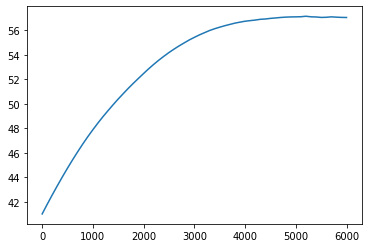

In [13]:
fig = plt.figure()
_ = plt.plot(training_history[:, 0], training_history[:, 2])

In [14]:
import pandas as pd

In [15]:
df_gru = pd.read_csv('{}_gru_training_history.csv'.format(path_prefix))
df_ffn = pd.read_csv('{}_training_history.csv'.format(path_prefix))

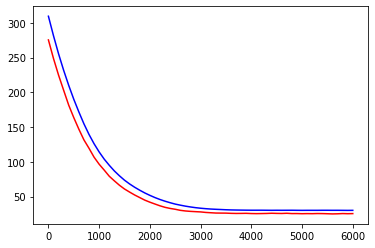

In [16]:
fig = plt.figure()
_ = plt.plot(df_gru['step'], df_gru['loss_function'], c='r')
_ = plt.plot(df_ffn['step'], df_ffn['loss_function'], c='b')